## Least-squared regression

### Imports

In [520]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.get_cachedir()
plt.style.use("default")
from numpy.random import randn
import time
from functools import wraps
import seaborn as sns

### Runtime

In [521]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Values

In [522]:
n = 500 # number of points
sigma = 2
sigma2 = 2*sigma**2
lam = 0.000001

# Approximation parameters
m = 20 # number of samples
w = randn(m) / sigma
b = np.random.rand(m)*2*np.pi
noise = randn(n)
# Example functions
x = randn(n)/2
y = np.cos(x) + noise * 1e-1

x_sort = np.sort(x)

### Gaussian kernel

In [523]:
def k_gauss(x, z): 
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k
    
@runtime
def K_gauss(x, y, n):
    Kxy = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Kxy[i, j] = k_gauss(x[i], y[j])
    return Kxy

#### Alpha

In [524]:
@runtime
def alpha_gauss(x, y, n):
    K = K_gauss(x, x, n)
    alpha_gauss = np.linalg.solve(K + lam*np.eye(n), y)
    return alpha_gauss
    
alpha_ = alpha_gauss(x, y, n)


 Function K_gauss took 1.6604 seconds

 Function alpha_gauss took 1.6761 seconds


#### Estimated function

In [525]:
@runtime
def function_gauss(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        sum = 0
        for j in range(n):
            sum = sum + alpha[j] * k_gauss(x_sort[i], x[j])
        f[i] = sum
    return f

func = function_gauss(x, n, alpha_)


 Function function_gauss took 1.5144 seconds


#### Plot

C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\58899647.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


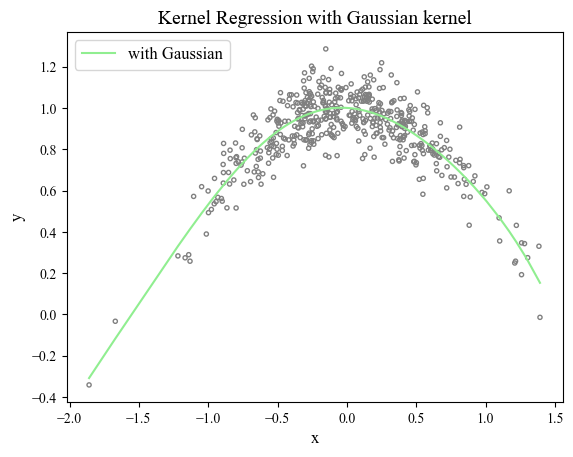

In [526]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})
fig1 = plt.figure(1)
plt.rc('text', usetex=False)
plt.scatter(x,y, facecolors ='none' , edgecolors = "gray" , marker = ".")
plt.plot(x_sort, func, c="lightgreen", label="with Gaussian")
plt.title("Kernel Regression with Gaussian kernel", fontsize=14)
plt.xlabel("x", fontsize = 12)
plt.ylabel("y", fontsize = 12)
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 } )
fig1.show()
plt.savefig("../src/figures_plot/lsr_regression_gauss.eps", format ="eps")

## Random Fourier Features

### Approximation 1

In [527]:
# Feature vector
def psi(x, w, b):
    return np.sqrt(2)*np.cos(w*x + b)

def k_approx1(x_i, z_i, w, b, m):
    return 1/m * np.sum(psi(x_i, w, b) * psi(z_i, w, b))

# Not in use
def K_approx1(x, z, w, b, m):
    K = np.zeros((n ,m))
    for i in range(n):
        for j in range(m):
            K[i, j] = k_approx1(x[i], z[j], w, b, m)
    return K

K_ = K_approx1(x, x, w, b, m)

#### Alpha

In [528]:
def alpha_approx1(x, y, lam, w, b, m):
    K = np.zeros((n ,m))
    for i in range(n):
        K[i, :] = psi(x[i], w, b)
    return np.linalg.inv(K.T @ K + lam*np.eye(m)) @ K.T @ y

alpha_approx = alpha_approx1(x, y, lam, w, b, m)

#### Estimated function

In [529]:
def function_approx1(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*psi(x_sort[i], w, b))
    return f

func_approx1 = function_approx1(x, n, alpha_approx)

#### Plot

C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\2870598237.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\2870598237.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


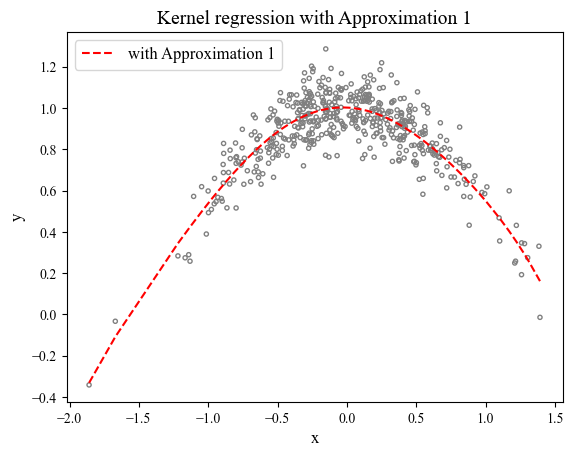

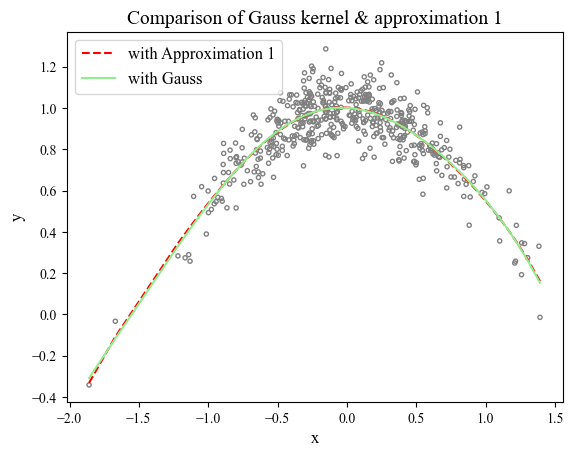

In [530]:
fig2 = plt.figure(2)
plt.scatter(x,y, facecolors ='none' , edgecolors = "gray" , marker = ".")
plt.plot(x_sort, func_approx1, c="r", label="with Approximation 1", ls = "--")
plt.title("Kernel regression with Approximation 1", fontsize = 14)
plt.xlabel("x", fontsize = 12)
plt.ylabel("y", fontsize = 12)
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 })
fig2.show()
plt.savefig("../src/figures_plot/lsr_regression_approx1.eps", format ="eps")

fig3 = plt.figure(3)
plt.scatter(x,y, facecolors ='none' , edgecolors = "gray" , marker = ".")
plt.plot(x_sort, func_approx1, c="r", label="with Approximation 1", ls = "--")
plt.plot(x_sort, func, c="lightgreen", label="with Gauss")
plt.title("Comparison of Gauss kernel & approximation 1", fontsize = 14)
plt.xlabel("x", fontsize = 12)
plt.ylabel("y", fontsize = 12)
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 })
fig3.show()
plt.savefig("../src/figures_plot/lsr_regression_gauss_approx1.eps", format ="eps")

### Approximation 2

In [531]:
def psi_cos(x, w, m):
    return 1/np.sqrt(m) * np.cos(w*x)

def psi_sin(x, w, m):
    return 1/np.sqrt(m) * np.sin(w*x)

def k_approx2(x, y, w, m):
    return np.sum(psi_cos(x, w, m)*psi_cos(y, w, m)) + np.sum(psi_cos(x, w, m)*psi_cos(y, w, m))

# Not in use
def K_approx2(x, y, w, n, m):
    K = np.zeros((n, m))
    for i in range(n):
        for j in range(m): 
            K[i, j] = k_approx2(x, y, w, m)
    return K

### Alpha

In [532]:
@runtime
def alpha_approx2(x, y, w, n, m):
    K = np.zeros((n, m))
    for i in range(n):
        K[i, :] = psi_cos(x[i], w, m) + psi_sin(x[i], w, m)
    alpha = np.linalg.inv(K.T @ K + lam*np.eye(m)) @ K.T @ y
    return alpha

alpha_2 = alpha_approx2(x, y, w, n, m)


 Function alpha_approx2 took 0.0088 seconds


#### Estimated function

In [533]:
@runtime
def function_approx2(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*(psi_cos(x_sort[i], w, m) + psi_sin(x_sort[i], w, m)))
    return f

func_approx2 = function_approx2(x, n, alpha_2)


 Function function_approx2 took 0.0100 seconds


#### Plot

C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\3787170858.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig4.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\3787170858.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig5.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


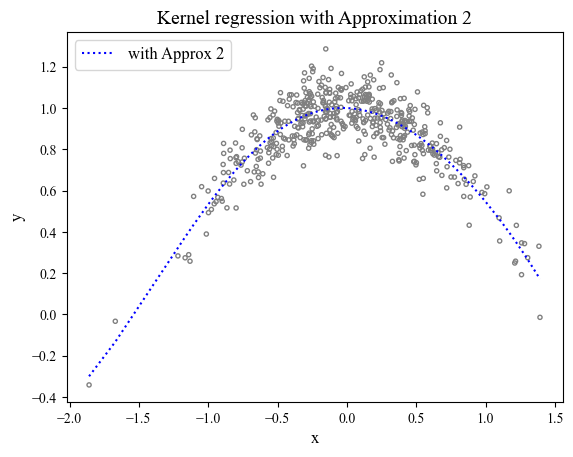

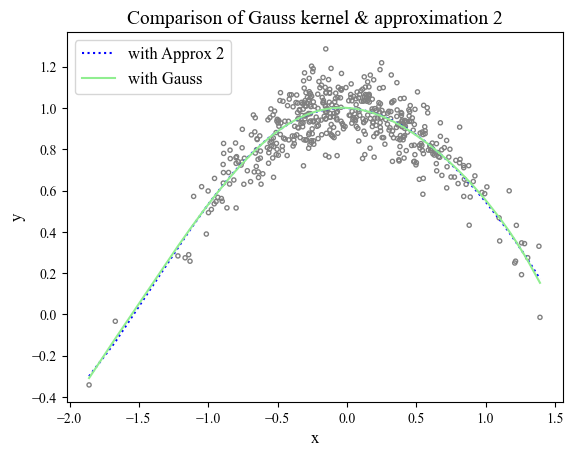

In [534]:
fig4 = plt.figure(4)
plt.scatter(x,y, facecolors ='none' , edgecolors = "gray" , marker = ".")
plt.plot(x_sort, func_approx2, c="b", label="with Approx 2", ls = ":")
plt.title("Kernel regression with Approximation 2", fontsize = 14)
plt.xlabel("x", fontsize = 12)
plt.ylabel("y", fontsize = 12)
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 } )
fig4.show()
plt.savefig("../src/figures_plot/lsr_regression_approx2.eps", format ="eps")

fig5 = plt.figure(5)
plt.scatter(x,y, facecolors ='none' , edgecolors = "gray" , marker = ".")
plt.plot(x_sort, func_approx2, c="b", label="with Approx 2", ls = ":")
plt.plot(x_sort, func, c="lightgreen", label="with Gauss")
plt.title("Comparison of Gauss kernel & approximation 2", fontsize = 14)
plt.xlabel("x", fontsize = 12)
plt.ylabel("y", fontsize = 12)
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 } )
fig5.show()
plt.savefig("../src/figures_plot/lsr_regression_gauss_approx2.eps", format ="eps")

## All plots

C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\533532114.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig6.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


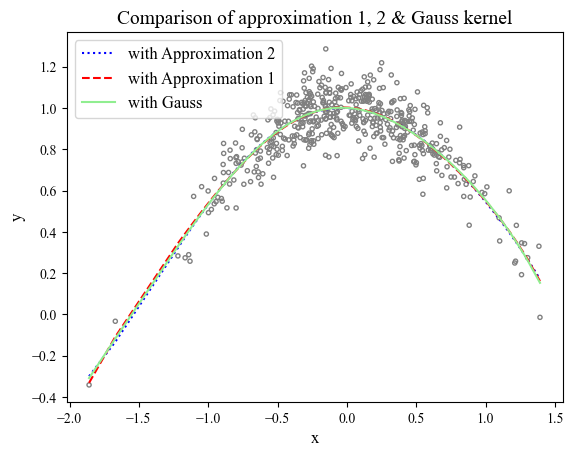

In [535]:
fig6 = plt.figure(6)
plt.scatter(x,y, facecolors ='none' , edgecolors = "gray" , marker = ".")
plt.plot(x_sort, func_approx2, c="b", label="with Approximation 2", ls = ":")
plt.plot(x_sort, func_approx1, c="r", label="with Approximation 1", ls = "--")
plt.plot(x_sort, func, c="lightgreen", label="with Gauss")
plt.title("Comparison of approximation 1, 2 & Gauss kernel", fontsize = 14)
plt.xlabel("x", fontsize = 12)
plt.ylabel("y", fontsize = 12)
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 } )
fig6.show()
plt.savefig("../src/figures_plot/lsr_regression_gauss_approx1_and_2.eps", format ="eps")

### Error

In [554]:
def error(f_gauss, f_approx): 
    sum = 0
    for i in range(len(f_gauss)):
        sum += f_gauss[i] - f_approx[i]
    return sum

error_1 = error(func, func_approx1)
error_2 = error(func, func_approx2)

print("Error between Gauss and approx 1:", error_1)
print("Error between Gauss and approx 2:", error_2)

def mean_squared_error(func_actual, func_approx):
    return np.square(np.subtract(func_actual, func_approx)).mean()

mse_1 = mean_squared_error(func, func_approx1)
mse_2 = mean_squared_error(func, func_approx2)
print("Mse for approx 1:", mse_1)
print("Mse for approx 2:", mse_2)

different_m = [5, 20, 50, 200]

w_list1 = []
w_list2 = []
w_list3 = []
w_list4 = []
w_total = [w_list1, w_list2, w_list3, w_list4]
b_list1 = []
b_list2 = []
b_list3 = []
b_list4 = []
b_total = [b_list1, b_list2, b_list3, b_list4]
for i in range(len(different_m)):
    m = different_m[i]
    w_total[i] = randn(m) / sigma
    b_total[i] = np.random.rand(m)*2*np.pi



Error between Gauss and approx 1: -3.3691284004794264e-05
Error between Gauss and approx 2: -1.2833294115166538e-06
Mse for approx 1: 6.901116051261031e-06
Mse for approx 2: 5.654440223913126e-06


## Box plot


 Function alpha_approx2 took 0.0056 seconds

 Function function_approx2 took 0.0076 seconds

 Function alpha_approx2 took 0.0061 seconds

 Function function_approx2 took 0.0070 seconds

 Function alpha_approx2 took 0.0075 seconds

 Function function_approx2 took 0.0072 seconds

 Function alpha_approx2 took 0.0271 seconds

 Function function_approx2 took 0.0084 seconds
[[ 7.79920639e-05 -4.58439895e-05 -3.53802903e-04  1.52197044e-03]
 [-3.42146696e-04  4.45455705e-05  6.60356291e-05 -2.38098245e-05]]


C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\1445235479.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig7.show()
C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\1445235479.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig8.show()
C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\1445235479.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig9.show()
C:\Users\Heli\AppData\Local\Temp\ipykernel_38836\1445235479.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig10.show()


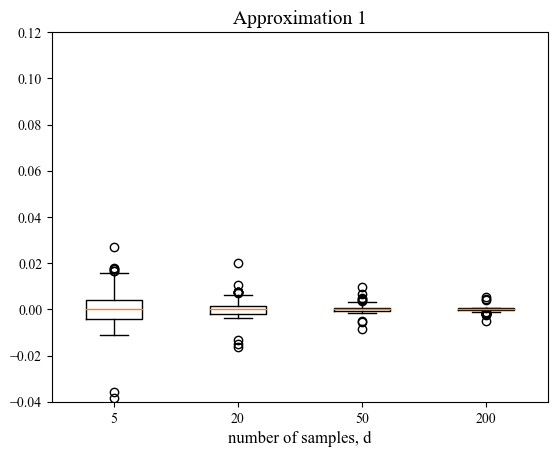

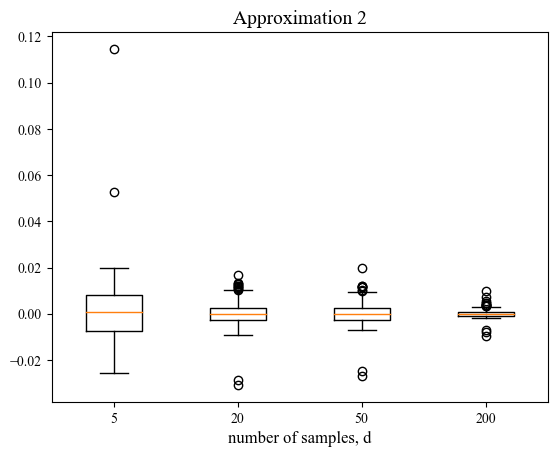

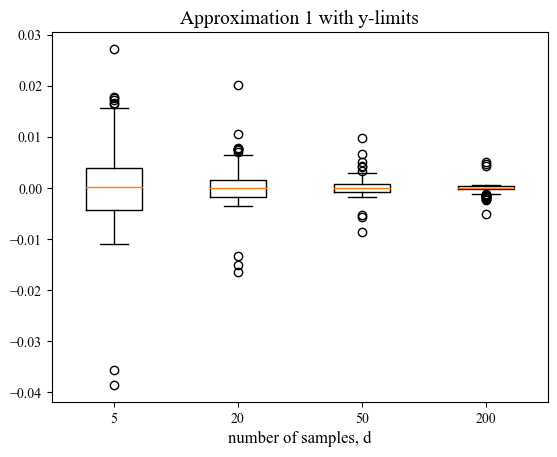

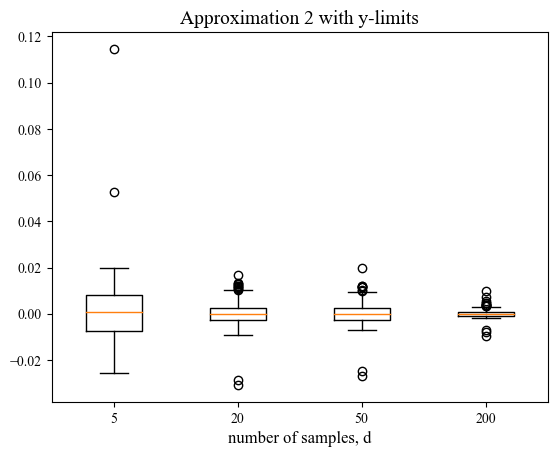

In [556]:
different_m = [5, 20, 50, 200]
u = np.zeros((n, len(different_m)))
v = np.zeros((n, len(different_m)))
sum = np.zeros((2, len(different_m)))
for i in range(len(different_m)):
    m = different_m[i]
    w = w_total[i]
    b = b_total[i]
    #w = randn(m) / sigma
    #b = np.random.rand(m)*2*np.pi
    alpha_app1 = alpha_approx1(x, y, lam, w, b, m)
    func_1 = function_approx1(x, n, alpha_app1)
    alpha_app2 = alpha_approx2(x, y, w, n, m)
    func_2 = function_approx2(x, n, alpha_app2)
    for j in range(len(func)):
        sum[0, i] += func[j] - func_1[j]
        sum[1, i] += func[j] - func_2[j]
        u[j, i] += func[j] - func_1[j]
        v[j, i] += func[j] - func_2[j]

print(sum) 

# Approximation 1
fig7 = plt.figure(7)
ax = fig7.add_subplot(1, 1, 1)
plt.title("Approximation 1", fontsize = 14)
ax.boxplot([u[:, 0], u[:, 1], u[:, 2], u[:, 3]], labels = different_m)
ax.set_xlabel('number of samples, d', fontsize=12)
ax.set_ylim(-0.04, 0.12)
fig7.show()
plt.savefig("../src/figures_plot/lsr_boxplot_approx1.eps", format ="eps")

# Approximation 2
fig8 = plt.figure(8)
ax2 = fig8.add_subplot(1, 1, 1)
plt.title("Approximation 2", fontsize = 14)
ax2.boxplot([v[:, 0], v[:, 1], v[:, 2], v[:, 3]], labels = different_m)
ax2.set_xlabel('number of samples, d', fontsize = 12)
#ax2.set_ylim(-0.04, 0.05)
fig8.show()
plt.savefig("../src/figures_plot/lsr_boxplot_approx2.eps", format ="eps")


# Approximation 1 zoomed
fig9 = plt.figure(9)
ax = fig9.add_subplot(1, 1, 1)
plt.title("Approximation 1 with y-limits", fontsize = 14)
ax.boxplot([u[:, 0], u[:, 1], u[:, 2], u[:, 3]], labels = different_m)
ax.set_xlabel('number of samples, d', fontsize=12)
#ax.set_ylim(-0.05, 0.05)
fig9.show()
plt.savefig("../src/figures_plot/lsr_boxplot_approx1_zoomed.eps", format ="eps")

# Approximation 2 zoomed
fig10 = plt.figure(10)
ax2 = fig10.add_subplot(1, 1, 1)
plt.title("Approximation 2 with y-limits", fontsize = 14)
ax2.boxplot([v[:, 0], v[:, 1], v[:, 2], v[:, 3]], labels = different_m)
ax2.set_xlabel('number of samples, d', fontsize = 12)
#ax2.set_ylim(-0.05, 0.05)
fig10.show()
plt.savefig("../src/figures_plot/lsr_boxplot_approx2_zoomed.eps", format ="eps")